In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

fixednesses = ['fixed', 'variable'] 
semantics_list = ['syntactical', 'special', 'random']
counts = ['single', 'multi']
model_names = ['meta-llama/Meta-Llama-3.1-8B-Instruct', 
               'Qwen/Qwen2.5-7B-Instruct',
               ]
dataset_names = ['imdb-small', 'paradetox',]
model_layers=  {
    'meta-llama/Meta-Llama-3.1-8B-Instruct': [15,16],
    'Qwen/Qwen2.5-7B-Instruct': [13, 14],
}
model_rename = {
    'meta-llama/Meta-Llama-3.1-8B-Instruct': 'Llama-3.1-8B-Inst',
    'Qwen/Qwen2.5-7B-Instruct': 'Qwen2.5-7B-Inst',
}
results = { 
           'model_name': [],
           'dataset_name': [],
           'Token Fixedness': [],
           'Token Semantics': [],
           'Token Multiplicity': [],
           'layer': [],
           'accuracy': [],
           }

import json 
# outputs/value_probers/Qwen/Qwen2.5-7B-Instruct/paradetox/fixed_special_single/BCEProber/42/layer_14_results.json
result_format = "outputs/value_probers/{model_name}/{dataset_name}/{fixedness}_{semantics}_{count}/BCEProber/42/layer_{layer}_results.json"
for model_name in model_names:
    for dataset_name in dataset_names:
        for fixedness in fixednesses:
            for semantics in semantics_list:
                if fixedness == "variable" and semantics == "special":
                    continue
                for count in counts:
                    for layer in model_layers[model_name]:
                        json_file = result_format.format(model_name=model_name, dataset_name=dataset_name, fixedness=fixedness, 
                                                         semantics=semantics, count=count, layer=layer)
                        if os.path.exists(json_file):
                            test_accs = json.load(open(json_file))['test_accs']
                            test_acc = test_accs[-1]
                            test_acc = float(max(test_accs))
                            results['model_name'].append(model_rename[model_name])
                            results['dataset_name'].append(dataset_name)
                            results['Token Fixedness'].append(fixedness.capitalize().strip())
                            results['Token Semantics'].append(semantics.capitalize().strip())
                            results['Token Multiplicity'].append(count.capitalize().strip())
                            results['layer'].append(layer)
                            results['accuracy'].append(test_acc)
                        else:
                            print(f"File {json_file} does not exist")

dfs = pd.DataFrame(results)
dfs['Token Fixedness'] = dfs['Token Fixedness'].str.capitalize()
dfs['Token Semantics'] = dfs['Token Semantics'].str.capitalize()
dfs['Token Multiplicity'] = dfs['Token Multiplicity'].str.capitalize()

In [2]:
order_sem = ["Special", "Syntactical",  "Random"]
order_mul = ["Single", "Multi"]
order_fix = ["Fixed", "Variable"]
dfs["Token Semantics"] = pd.Categorical(dfs["Token Semantics"], order_sem, ordered=True)
dfs["Token Multiplicity"] = pd.Categorical(dfs["Token Multiplicity"], order_mul, ordered=True)
dfs["Token Fixedness"] = pd.Categorical(dfs["Token Fixedness"], order_fix, ordered=True)


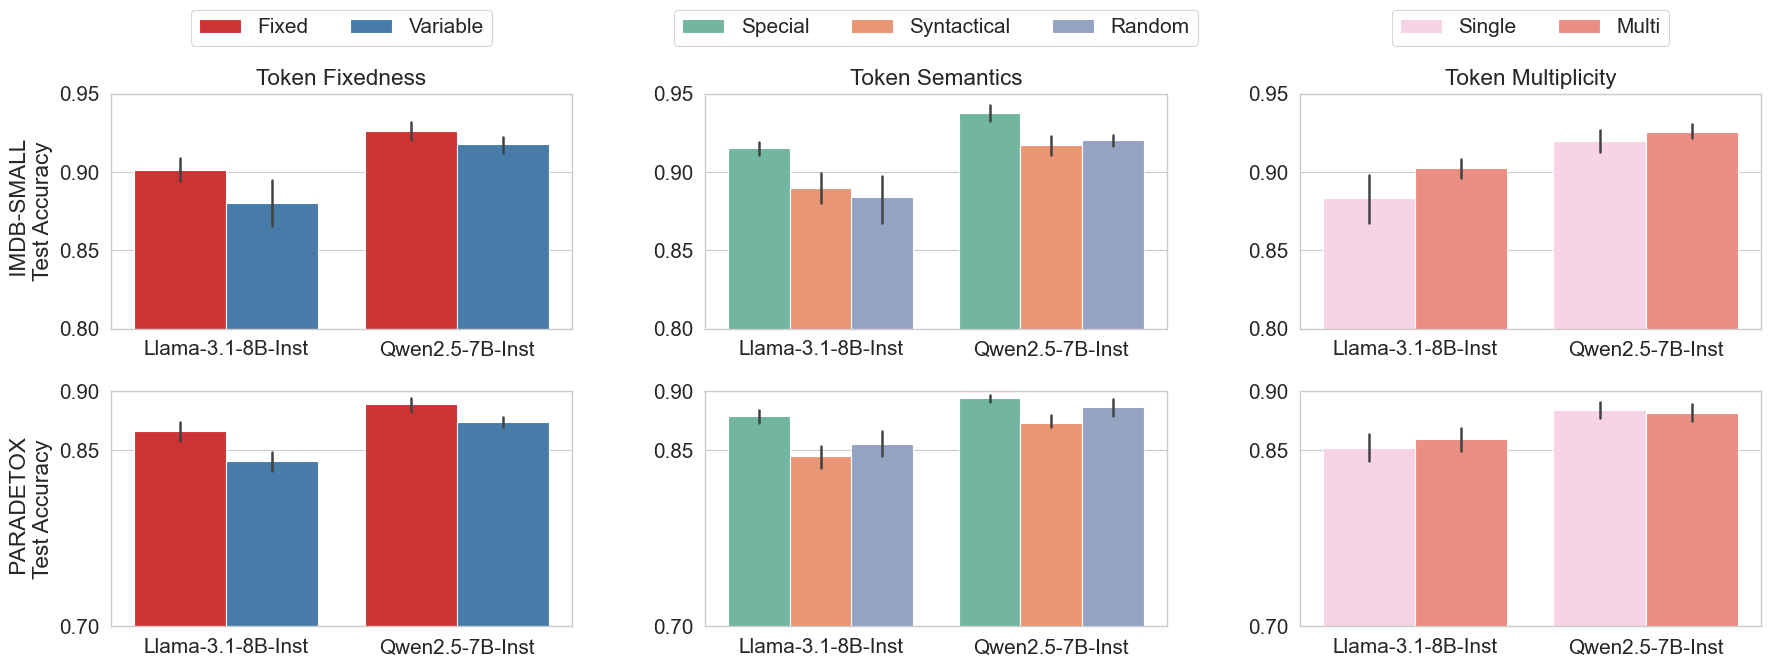

In [5]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.7)
fig, axes = plt.subplots(2,3, figsize=(18, 7), sharey=False)
for data_idx, dataset_name in enumerate(dfs.dataset_name.unique()):
    temp = dfs[dfs.dataset_name == dataset_name]
    sns.barplot(x='model_name', y='accuracy', data=temp, hue='Token Fixedness', ax=axes[data_idx, 0], palette="Set1", legend=True if data_idx == 0 else False   )
    sns.barplot(x='model_name', y='accuracy', data=temp, hue='Token Semantics', ax=axes[data_idx, 1], palette="Set2", legend=True if data_idx == 0 else False )
    sns.barplot(x='model_name', y='accuracy', data=temp, hue='Token Multiplicity', ax=axes[data_idx, 2], palette="Set3_r", legend=True if data_idx == 0 else False)
    if data_idx == 0:
        axes[data_idx, 0].set_title("Token Fixedness")
        axes[data_idx, 1].set_title("Token Semantics")
        axes[data_idx, 2].set_title("Token Multiplicity")
        anchor = (0.5, 1.4)
        axes[0, 0].legend(loc='upper center', bbox_to_anchor=anchor, ncol=3, fontsize=15)  
        axes[0, 1].legend(loc='upper center', bbox_to_anchor=anchor, ncol=3, fontsize=15)  
        axes[0, 2].legend(loc='upper center', bbox_to_anchor=anchor, ncol=3, fontsize=15)  
    if data_idx == 0:
        for i in range(3):
            axes[data_idx, i].set_ylim(0.8, 0.95)
            axes[data_idx, i].set_yticks([0.8, 0.85, 0.9, 0.95])
    else:
        for i in range(3):
            axes[data_idx, i].set_ylim(0.7, 0.90)
            axes[data_idx, i].set_yticks([0.7, 0.85,  0.90])

    for ax in axes[data_idx]:
        ax.set_xlabel("")
        ax.set_ylabel(f" {dataset_name.upper()}\nTest Accuracy")
        
axes[0, 1].set_ylabel(f"")
axes[0, 2].set_ylabel(f"")
axes[1, 1].set_ylabel(f"")
axes[1, 2].set_ylabel(f"")
plt.tight_layout()
plt.savefig("assets/accuracy_plot.png", dpi=300)